<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/ML_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatische Erkennung von Musikinstrumenten
**Gruppe:** Grumpy

# Importe
Im Folgenden werden zunächst alle benötigten Libarys importiert die für dieses Notebook notwändig sind.

In [ ]:
! pip install keras-cv tensorflow --upgrade
! pip install keras_core

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from glob import glob
import cv2
import json
from keras.models import load_model
import keras_cv
from tensorflow.keras.utils import plot_model
from IPython.display import Image
#from keras.utils import to_categorical
#from keras.src.layers.preprocessing.normalization import Normalization

Using TensorFlow backend


# Der Datensatz

Dieser Abschnitt beinhaltet alle den Datensatz betreffenden Grundlagen. Hierzu gehören:
* der Hintergrund des Datensatzes,
* der Datenimport,
* das Definieren der Trainings-, Test- und Validierungsdatensätze,
* sowie die Datenexploration.

## Hintergrund

Der für dieses Projekt verwendete Datensatz [30 Musical Instruments -Image Classification](https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification?select=instruments.csv) stammt von Kaggle.com.

Die Bilder wurden von [Gerry ](https://www.kaggle.com/gpiosenka) bereitsgestellt und stammen aus einer strukturierten Internetrecherche.

Die Struktur der Daten kann auf Kaggle eingesehen werden und hat einee entscheidende Rolle in der Auswahl der Daten gespielt. Genauer stand für dieses Projekt die Verwendbarkeit im Fokus. Hier war eine Mindestanzahl an Bildern in geeigneter Struktur erforderlich.

Die Bilddaten sind nach Klassen in Ordner mit dem jeweiligen Namen strukturiert, was mit dem erforderlichen Input-Format der [image_dataset_from_directory](https://keras.io/api/data_loading/image/) funktion von Keras übereinstimmt.

Zusätzlich ist die Menge der Daten mit 5093 Bildern zwar ausbaufähig, für die Zwecke dieses Projektes jedoch ausreichend.  

Schließlich sprach noch die Vorverarbeitung für diesen Datensatz. Die Bilder wurden bereits auf Duplikate geprüft und in das einheitliche Format von 224 x 224 RGB gebracht, sodass diese Arbeiten in der vorverarbeitung eingesparrt werden können.


## Datenimport

Zunächst müssen die Daten aus Kaggle geladen werden. Hierfür wird die Kaggle API verwendet.

Für eine leichtere Kollaboration wird der private Kaggle-Token hard-codet in der Variable `json_token` gespeichert und in die Colab-Umgebung geladen.

Im Anschluss wird die Funktion `import_data()` definiert. Diese bildet alle notwendigen Schritte ab, um sich mittels des Tokens mit der Kaggle API zu verbinden und den Datensatz `musical-instruments-image-classification` zu laden.

*Referenz:*

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
# Hard-Coden des privaten Kaggle-Tokens
json_token = {"username":"mrommel","key":"ec48fc1622dfc43b58152e93be8b5a6a"}
with open('kaggle.json', 'w', encoding='utf-8') as file:
  json.dump(json_token, file, ensure_ascii=False, indent=4)

def import_data():
  '''
  Diese Funktion nutzt die Kaggle API mittels des json_token Objektes,
  um den musical-instruments-image-classification Datensatzes zu laden
  und zu entpacken.
  '''
  ! pip install -q kaggle
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download gpiosenka/musical-instruments-image-classification
  ! unzip musical-instruments-image-classification.zip

import_data()

## Trainings-, Test- und Validationsdatensaetze definieren

Im folgenden werden die Trainings-, Test- und Validierungsdaten geladen und als Datensatz definiert.

Hierfür wird zunächst die funktion `load_data` definiert. Diese Funktion vermeidet Code redundanzen, welche durch das Laden der drei Datensätze andernfalls entstünden. Hier wurden alle gleichbleibenden Argumente bereits gesetzt. Die Funktion nimmt das Argument subset entgegen. `subset` ist der jeweilige Ordner (Train, Test oder Valid), aus welchem der Datensatz gebildet wird.

*Referenzen:*

https://keras.io/api/data_loading/image/

https://www.tensorflow.org/tutorials/images/classification

In [4]:
def load_data(subset):
  '''
  Diese Funktion lädt die Daten eines definierten Ordners und speichert diese
  in Bild-Label Kombinationen gemäß der Ordnerstruktur ab.

  *Args*
  subset: Nimmt einen String-Wert. Gibt den Ordner an, in dem sich die Daten befinden.
  '''
  return tf.keras.utils.image_dataset_from_directory(
    f"/content/{subset}",
    labels="inferred",
    #label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

In [5]:
# Laden der jeweiligen Datensätze

train_data = load_data("train")
test_data = load_data("test")
valid_data = load_data("valid")

Found 4793 files belonging to 30 classes.
Found 150 files belonging to 30 classes.
Found 150 files belonging to 30 classes.


## Datenexploration

TEXT ZUR DATENEXPLORATION

Zunächst werden die resultierenden Klassen geprüft. Diese sollten die Namen der 30 Instrumente beinhalten.

In [27]:
class_names = train_data.class_names
i = 0
for class_name in class_names:
  i += 1
  print(f"Instrument {i}: {class_name}")

Instrument 1: Didgeridoo
Instrument 2: Tambourine
Instrument 3: Xylophone
Instrument 4: acordian
Instrument 5: alphorn
Instrument 6: bagpipes
Instrument 7: banjo
Instrument 8: bongo drum
Instrument 9: casaba
Instrument 10: castanets
Instrument 11: clarinet
Instrument 12: clavichord
Instrument 13: concertina
Instrument 14: drums
Instrument 15: dulcimer
Instrument 16: flute
Instrument 17: guiro
Instrument 18: guitar
Instrument 19: harmonica
Instrument 20: harp
Instrument 21: marakas
Instrument 22: ocarina
Instrument 23: piano
Instrument 24: saxaphone
Instrument 25: sitar
Instrument 26: steel drum
Instrument 27: trombone
Instrument 28: trumpet
Instrument 29: tuba
Instrument 30: violin


Zusätzlich werden einige Bilder des Datensatzes betrachtet, um ein Gefühlt für die Bilder zu bekommen.
Hierfür werden 3 Bilder des Trainingsdatensatzes `train_data` mit ihrem Label dargestellt.

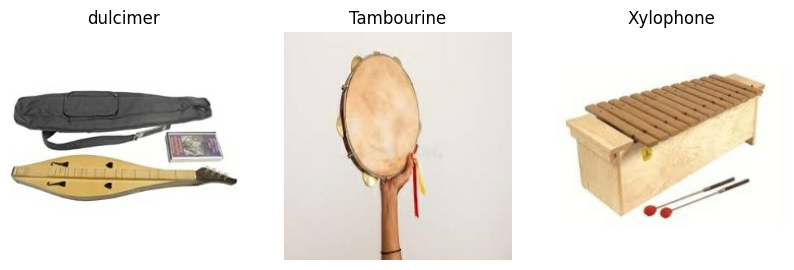

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Des weiteren wird das Format der Bilder geprüft.
Die funktion `.shape` gibt die beim Laden der Bilder definierte `batch size`, sowie Höhe, Breite und Anzahl der Farbkanäle der Bilder an.

Der Output zeigt, dass die Bilder 224x224 Pixel groß sind und in Farbe sind.

In [29]:
for images, labels in train_data.take(1):
  print(images.shape)

(32, 224, 224, 3)


# Modellerstellung
Im folgenden Abschnitt werden alle notewendigen Aspekte der Modellerstellung druchlaufen.

Hier zu gehören:
 * die Datenvorverarbeitung,
 * das Erstellen einer Modellarchitektur,
 * das Training und Testen des Modells,
 * sowie das Fine-Tuning.

Zum Abschluss wird die Performance des Modells mittels Cross-Validierung geprüft.

## Datenvorverarbeitung

Die Datenvorverarbeitung bietet die Möglichkeit, die Bilder zu verändern. Ein Mögliches Feld sind Augmentationen, welche verwendet werden, um die Menge der Bilder zu erhöhen oder zu diversifizieren. Beispiele hierfür sind das verändern des Kontrastes, sowie das spiegeln und drehen der Bilder.

Ein weiterer Anwendungsbereich ist die reduktion der Bilddaten. Dies kann sinnvoll sein, wenn der Detailgrad der Bilder hörer ist, als es für den Anwendungsfall von nöten ist. Da die vorliegenden Bilddaten mit 224x224 Pixeln in RGB verhältnismäßig groß sind, wird mit derartigen Methoden experimentiert.

Im Folgenden werden die Bilder verkleinert, von Farb- zu schwarz-weiß-Bildern verändert und normalisiert.

Referenzen:

https://www.tensorflow.org/tutorials/images/classification

https://keras.io/guides/preprocessing_layers/

https://chat.openai.com/share/4211047c-1904-4c0e-9ad1-9dc3c590233d


### Ändern der Farbkanäle

Im Folgenden werden die Farbkanäle von drei auf einen reduziert. Dies konvertiert die Bilder von Farb- zu schwarz-weiß Bildern.

Hierfür wird zunächst die Funktion `to_greyscale()` definiert. Hierdurch werden Coderedundanzen vermieden. Die Funktion nimmt das Argument `subset`, welches auf den jeweiligen Datensatz zeigt.

Im Anschluss wird die Funktion für Trainings-, Test- und Validierungsdatansatz aufgerufen und die Ergebnisse mit dem Prefix *greyscale_* gesichert.

Mittels der Funktion `.shape` kann im Anschluss erneut das Format der Bilder angezeigt werden. Man kann hier erkennen, dass sich die Farbkanäle von drei auf einen reduziert haben.

Schließlich werden die konvertierten Bilder visuell dargestellt.

In [32]:
def to_greyscale(subset):
  '''
  Diese Funktion kovertiert Farbbilder in schwarz-weiß Bilder.

  *Args:
  subset: Gibt den Datensatz an, der konvertiert werden soll.
  '''
  return subset.map(lambda x,y: (keras_cv.layers.preprocessing.Grayscale()(x), y))

In [33]:
# Konvertieren der Unterdatensätze in schwarz-weiß Bilder

greyscale_train_data = to_greyscale(train_data)
greyscale_test_data = to_greyscale(test_data)
greyscale_valid_data = to_greyscale(valid_data)

In [34]:
for images, labels in greyscale_train_data.take(1):
  print(images.shape)

(32, 224, 224, 1)


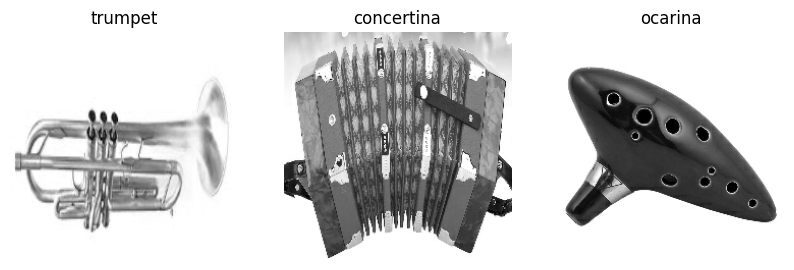

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in greyscale_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    #cmap gibt die Farbkanäle an.
    #Da der Default RGB ist, muss dieser für schwarz-weiß Bilder definiert werden.
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")

    plt.title(class_names[labels[i]])
    plt.axis("off")

### Ändern der Bildgröße
In diesem Abschnitt wird die Bildgröße verändert.

Zunächst wird die Funktion `resize()` definiert. Hierdurch werden Coderedundanzen vermieden. Die Funktion nimmt das Argument `subset`, welches auf den jeweiligen Datensatz zeigt. Zusätzlich werden `height`und `width`übergeben. Hierüber werden die gewünschte Breite und Höhe des Outputbildes definiert.

Im Anschluss wird die Funktion für Trainings-, Test- und Validierungsdatansatz aufgerufen und die Ergebnisse mit dem Prefix *resize_* gesichert.

Mittels der Funktion `.shape` kann im Anschluss erneut das Format der Bilder angezeigt werden. Man kann hier erkennen, dass sich die Anzahl der Pixel in Höhe und Breite reduziert hat.

Schließlich werden die konvertierten Bilder visuell dargestellt. Die verschlechterung der Qualität ist deutlich sichtbar.

In [36]:
def resize(subset, height, width):
  '''
  Diese Funktion verändert die Größe von Bildern.

  *Args:
  subset: Gibt den Datensatz an, der konvertiert werden soll.
  height: Gibt die gewünschte Höhe an.
  width: Gibt die gewünschte Breite an.
  '''
  return subset.map(lambda x,y: (tf.keras.layers.Resizing(height, width)(x), y))

In [37]:
# Verkleinerung der Bilder der Unterdatensätze

resized_train_data = resize(train_data, 32,32)
resized_test_data = resize(test_data, 32,32)
resized_valid_data = resize(valid_data, 32,32)

In [38]:
for images, labels in resized_train_data.take(1):
  print(images.shape)

(32, 32, 32, 3)


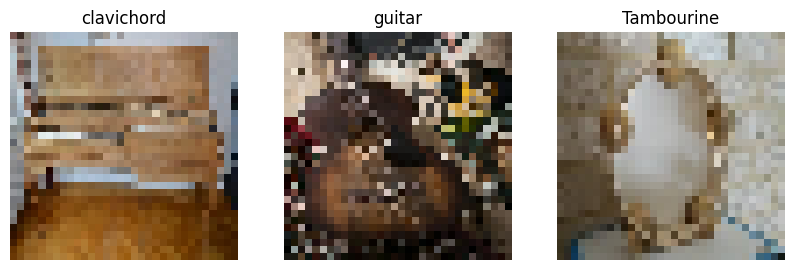

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in resized_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalisieren der Pixelwerte

Die Pixelwerte der jeweiligen Bilder liegen zwischen 0 und 255.

Um Werte zwischen 0 und 1 zu erlangen, werden die Pixelwerte daher durch 255 geteilt.

In [ ]:
# Minimum und Maximum der Pixel eines Beispielbildes abfragen

image_batch, labels_batch = next(iter(train_data))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [41]:
def normalize(subset):
  return subset.map(lambda x,y: (tf.keras.layers.Rescaling(1/255)(x), y))

In [43]:
# Normalisieren der Unterdatensätze

normal_train_data = normalize(train_data)
normal_test_data = normalize(test_data)
Normalization_valid_data = normalize(valid_data)

In [44]:
# Minimum und Maximum der Pixel nach dem Normalisieren abfragen

image_batch, labels_batch = next(iter(normal_test_data))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


### One-Hot Encoding

Da der Datensatz Kategorische Label hat, welche für CNNs ungeeignet sind, müssen diese Dummy Codiert werden.

Hierfür wird zunächst die Funktion `one_hot ` definiert. Diese nimmt das Argument `subset `, was auf den Datensatz zeigt, der Dummy codiert werden soll.

Im Anschluss wird die Funktion auf die drei Unterdatensätze angewandt.

In [63]:
# Ausganslage analysieren

for image, label in train_data.take(1):
    print("Label:", label.numpy())

Label: [24 28 15 16 21 25  0 29  1  1  4 15  6 15 25 12 13  8  9 25 11 25  9 17
  7 22 13 12  5  1 11 11]


In [6]:
def one_hot(subset):
  '''
  Funktion die die Labels eines Datensatzes Dummy codiert.

  *Args:
  subset: Gibt den Datensatz an der Dummy codiert werden soll.
  '''
  return subset.map(lambda x,y: (x, tf.one_hot(y,30)))

In [7]:
# Dummy codieren der Unterdatensätze

one_hot_train_data = one_hot(train_data)
one_hot_test_data = one_hot(test_data)
one_hot_valid_data = one_hot(valid_data)

In [ ]:
# Label überprüfen

for image, one_hot_label in one_hot_train_data.take(1):
    print("One-Hot Label:", one_hot_label.numpy())

## Modellarchitektur

Die Literaturrecherche zeigte verschiedenne CNN-Architekturen, welche gute bis sehr gute Ergebnisse in der Objekterkennung erlangen. Die kleinste davon ist AlexNet. Aus diesem Grund wird zunächst eine AlexNet Architektur erstellt, um dies als Referenz und Grundlage zu verwenden.

Im Anschluss kann das Modell über `model.summary() `untersucht werden.

*Referenzen:*

https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5

https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98



In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    input_shape= (224,224,3),
    filters=96,
    kernel_size=(11,11),
    strides=(4,4),
    activation="relu",
    #padding=0,
    ))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(5,5),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
model.add(tf.keras.layers.Dense(
    units=4096,
    activation= "relu"
))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))


In [47]:
# Übersicht der Layer und Parameter des Modells aufrufen

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 256)       8

In [ ]:
# Hierarchisches Diagram des Modells darstellen

plot_model(model, to_file='convnet.png', show_shapes=True,
                 show_layer_names=True)
Image(filename='convnet.png')

# Code aus dem Buch Seite 736

## Modell Training und Test

In diesem Abschnitt wird das Modell mittels `.compile` zunächst erstellt.
Im Anschluss wird dieses mit den ausgewählten Daten trainiert und getestet.

In [9]:
# Modell erstellen

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
# Modell trainieren und testen

model.fit(
    one_hot_train_data,
    epochs=5,
    validation_data=one_hot_test_data,
)

Epoch 1/5
150/150 [==============================] - 22s 62ms/step - loss: 10.8410 - accuracy: 0.0513 - val_loss: 3.3977 - val_accuracy: 0.0400
Epoch 2/5
150/150 [==============================] - 6s 41ms/step - loss: 3.3601 - accuracy: 0.0630 - val_loss: 3.4053 - val_accuracy: 0.0467
Epoch 3/5
150/150 [==============================] - 8s 48ms/step - loss: 3.3535 - accuracy: 0.0641 - val_loss: 3.4002 - val_accuracy: 0.0400
Epoch 4/5
150/150 [==============================] - 6s 37ms/step - loss: 3.3369 - accuracy: 0.0666 - val_loss: 3.4090 - val_accuracy: 0.0400
Epoch 5/5
150/150 [==============================] - 8s 49ms/step - loss: 3.3423 - accuracy: 0.0705 - val_loss: 3.3924 - val_accuracy: 0.0467


In [14]:
# Modell trainieren und testen

history = model.fit(
    one_hot_train_data,
    epochs=10,
    validation_data=one_hot_test_data,
)

Epoch 1/10
150/150 [==============================] - 6s 41ms/step - loss: 0.1802 - accuracy: 0.9702 - val_loss: 13.4640 - val_accuracy: 0.3667
Epoch 2/10
150/150 [==============================] - 6s 37ms/step - loss: 0.6223 - accuracy: 0.9395 - val_loss: 13.2335 - val_accuracy: 0.3400
Epoch 3/10
150/150 [==============================] - 6s 39ms/step - loss: 0.4704 - accuracy: 0.9311 - val_loss: 13.8238 - val_accuracy: 0.3800
Epoch 4/10
150/150 [==============================] - 6s 42ms/step - loss: 0.2809 - accuracy: 0.9543 - val_loss: 13.7993 - val_accuracy: 0.3600
Epoch 5/10
150/150 [==============================] - 7s 45ms/step - loss: 0.2047 - accuracy: 0.9627 - val_loss: 13.1262 - val_accuracy: 0.3400
Epoch 6/10
150/150 [==============================] - 6s 39ms/step - loss: 0.3209 - accuracy: 0.9526 - val_loss: 11.9111 - val_accuracy: 0.3600
Epoch 7/10
150/150 [==============================] - 7s 46ms/step - loss: 0.2638 - accuracy: 0.9503 - val_loss: 15.4237 - val_accuracy:

Nachdem das Modell trainiert und getestet wurde, wird der Verlauf der Accuracy über die Epochen hinweg visualisiert.

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy


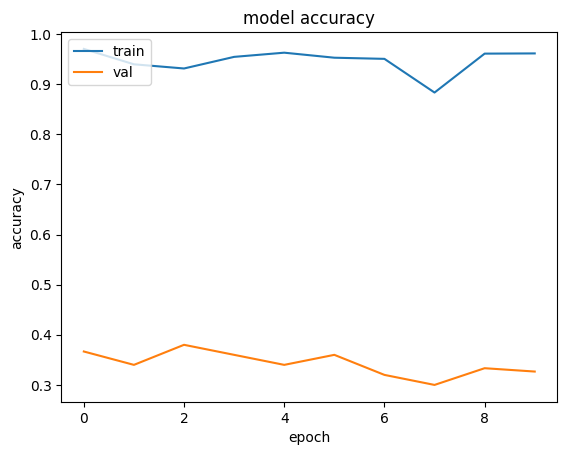

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()